In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Upload Data- Make sure data is loaded in your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upload Data from Google Drive
file_path = '/content/drive/My Drive/YRBS_2023.csv'

df = pd.read_csv(file_path)
df.head()



,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,QNILLICT,QNOBESE,QNOWT,WEIGHT,STRATUM,PSU,BMIPCT,RACEETH,Q6ORIG,Q7ORIG
0,3.0,1.0,1.0,NaN,C,1.65 81.6544111131112212212212211211121111,81.6544111131112212212212211211121111111111111...,4.0,4.0,1.0,...,NaN,1.0,2.0,0.8614103 1629497.08 505180,103,16294,97.08 505180,NaN,505,180
1,4.0,2.0,1.0,2.0,E,51111111222212231222211211121111,5111111122221223122221121112111111111111111111...,5.0,1.0,1.0,...,2.0,NaN,NaN,0.8920103 16294 . 5N N233,103,16294,. 5N N233,5.0,N N,233
2,5.0,2.0,3.0,2.0,E,1.68 74.8453231111112212212212211151112211,74.8453231111112212212212211151112211361111111...,5.0,3.0,2.0,...,1.0,2.0,1.0,0.5081103 1629492.26 5506165,103,16294,92.26 5506165,5.0,506,165
3,6.0,1.0,2.0,2.0,E,41281131112112212212211211117811,4128113111211221221221121111781135212845211211...,4.0,1.0,2.0,...,1.0,NaN,NaN,1.1759103 16294 . 5N N105,103,16294,. 5N N105,5.0,N N,105
4,3.0,2.0,1.0,2.0,E,1.85 56.7051111111312212112212111151111131,56.7051111111312212112212111151111131352122111...,5.0,1.0,1.0,...,2.0,2.0,2.0,0.8920103 16294 7.57 5601125,103,16294,7.57 5601125,5.0,601,125


In [ ]:
# STEP 2: Check column names and types
df.info()

# Clean column names if needed (remove whitespace, etc.)
df.columns = df.columns.str.strip()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20103 entries, 0 to 20102
Columns: 250 entries, Q1 to Q7ORIG
dtypes: float64(240), int64(2), object(8)
memory usage: 38.3+ MB


In [ ]:
# STEP 3: Select all columns of interest from the dataset

# These include:
# - mental health outcomes
# - screen time and activity predictors
# - control/demographic variables
# - additional predictors like sleep, bullying, alcohol, safety
columns = ['Q1', 'Q2', 'Q3',                # Demographics: Age, Sex, Race
           'Q25', 'Q24',                   # Cyberbullying, In-school bullying
           'Q26', 'Q27', 'Q28', 'Q29',     # Mental health outcomes
           'Q76', 'Q80', 'Q84', 'Q86',     # Activity, social media, recent MH, household
           'Q31', 'Q19', 'Q43']            # Sleep, alcohol, unsafe at school

df = df[columns]



In [ ]:
# STEP 4: Rename columns to help understand better
df = df.rename(columns={
    'Q1': 'Age',
    'Q2': 'Sex',
    'Q3': 'Race',
    'Q25': 'Cyberbullying',
    'Q24': 'SchoolBullying',
    'Q26': 'Sadness',
    'Q27': 'SuicideIdeation',
    'Q28': 'SuicidePlan',
    'Q29': 'SuicideAttempt',
    'Q76': 'PhysicalActivity',
    'Q80': 'SocialMediaUse',
    'Q84': 'RecentMentalHealth',
    'Q86': 'HouseholdInstability',
    'Q31': 'SleepHours',
    'Q19': 'AlcoholUse',
    'Q43': 'UnsafeAtSchool'
})


In [ ]:
# STEP 5: Recode selected variables into binary indicators

# 1 = YES, 2 = NO questions (convert to 1 and 0)
df['sadness_bin'] = df['Sadness'].map({1: 1, 2: 0})
df['cyberbully_bin'] = df['Cyberbullying'].map({1: 1, 2: 0})
df['school_bully_bin'] = df['SchoolBullying'].map({1: 1, 2: 0})
df['alcohol_use_bin'] = df['AlcoholUse'].map({1: 1, 2: 0})
df['unsafe_school_bin'] = df['UnsafeAtSchool'].map({1: 1, 2: 0})

# Physical activity: 5+ days of 60+ minutes = 1
df['active_bin'] = df['PhysicalActivity'].apply(lambda x: 1 if isinstance(x, (int, float)) and x >= 5 else 0)

# Social media use: 5+ hours = high use (1), otherwise low (0)
df['high_sm_use'] = df['SocialMediaUse'].apply(lambda x: 1 if x in [4, 5] else 0 if x in [1, 2, 3] else np.nan)

# Sleep: less than 6 hours = sleep-deprived
df['sleep_deprived'] = df['SleepHours'].apply(lambda x: 1 if isinstance(x, (int, float)) and x < 6 else 0)

# Drop rows with missing key binary columns
df.dropna(subset=['sadness_bin', 'cyberbully_bin', 'school_bully_bin',
                  'active_bin', 'high_sm_use', 'sleep_deprived'], inplace=True)


In [ ]:
# STEP 6: Prepare for modeling

# Features we want to use
features = ['cyberbully_bin', 'school_bully_bin', 'active_bin', 'high_sm_use',
            'sleep_deprived', 'alcohol_use_bin', 'unsafe_school_bin',
            'HouseholdInstability', 'Sex', 'Race']

# Target variable: sadness
target = 'sadness_bin'

# encode categorical variables (e.g. Race, Sex, Household)
df_model = pd.get_dummies(df[features + [target]], columns=['HouseholdInstability', 'Sex', 'Race'], drop_first=True)

# Separate into X (features) and y (target)
X = df_model.drop(columns=[target])
y = df_model[target]


Dealing with variables with missing values

In [ ]:
# Impute and flag missing values

# Sex and Race - Impute with mode
df['Sex'] = df['Sex'].fillna(df['Sex'].mode()[0])
df['Race'] = df['Race'].fillna(df['Race'].mode()[0])

# HouseholdInstability - Impute with mode and add missing flag
df['HouseholdInstability_missing'] = df['HouseholdInstability'].isna().astype(int)
df['HouseholdInstability'] = df['HouseholdInstability'].fillna(df['HouseholdInstability'].mode()[0])

# Binary features - Impute with 0 and add missing flags
for col in ['alcohol_use_bin', 'unsafe_school_bin']:
    df[f'{col}_missing'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(0)


2.1 Univariate Analysis with chi-square tests for each feature with the sadness target variable


 Analyzing Feature: cyberbully_bin
cyberbully_bin
0.0    2757
1.0     448
Name: count, dtype: int64


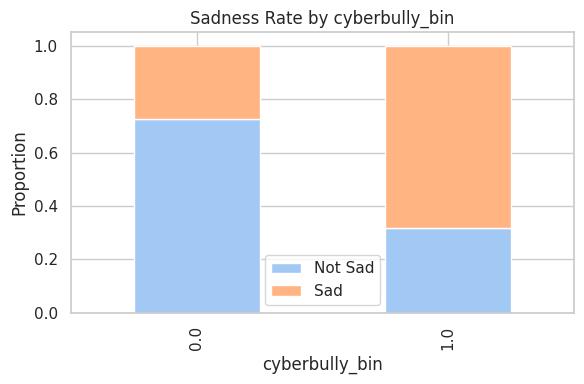

Chi-square p-value = 0.0000

 Analyzing Feature: school_bully_bin
school_bully_bin
0.0    2585
1.0     620
Name: count, dtype: int64


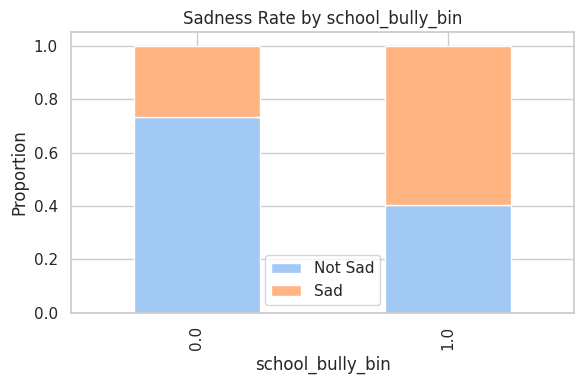

Chi-square p-value = 0.0000

 Analyzing Feature: active_bin
active_bin
1    1703
0    1502
Name: count, dtype: int64


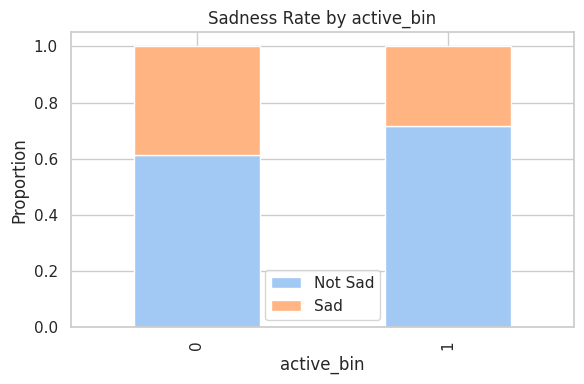

Chi-square p-value = 0.0000

 Analyzing Feature: high_sm_use
high_sm_use
0.0    1624
1.0    1581
Name: count, dtype: int64


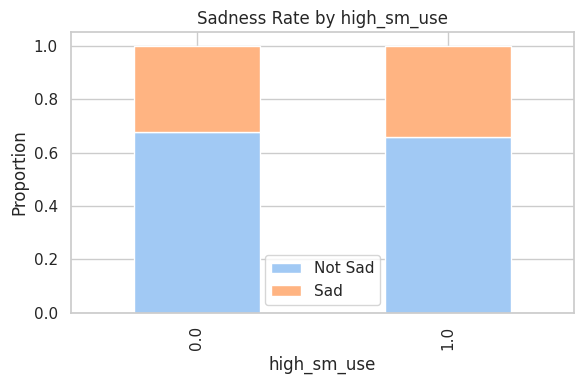

Chi-square p-value = 0.2890

 Analyzing Feature: sleep_deprived
sleep_deprived
1    3050
0     155
Name: count, dtype: int64


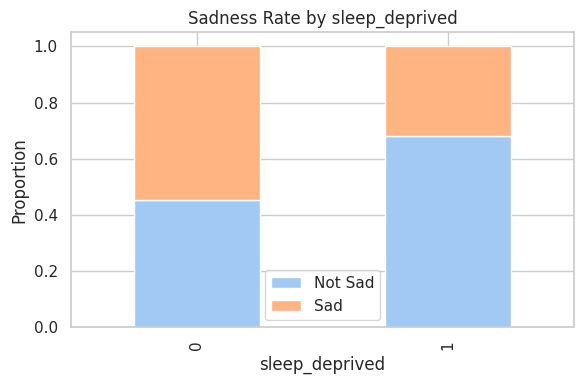

Chi-square p-value = 0.0000

 Analyzing Feature: alcohol_use_bin
alcohol_use_bin
0.0    2971
1.0     234
Name: count, dtype: int64


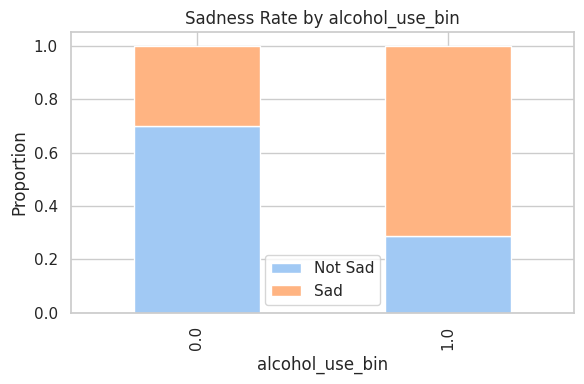

Chi-square p-value = 0.0000

 Analyzing Feature: unsafe_school_bin
unsafe_school_bin
1.0    2446
0.0     759
Name: count, dtype: int64


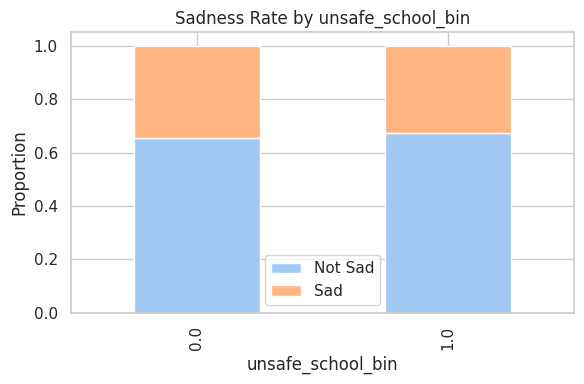

Chi-square p-value = 0.3422

 Analyzing Feature: HouseholdInstability
HouseholdInstability
1.0    3008
2.0      82
7.0      41
3.0      38
4.0      21
6.0      10
5.0       5
Name: count, dtype: int64


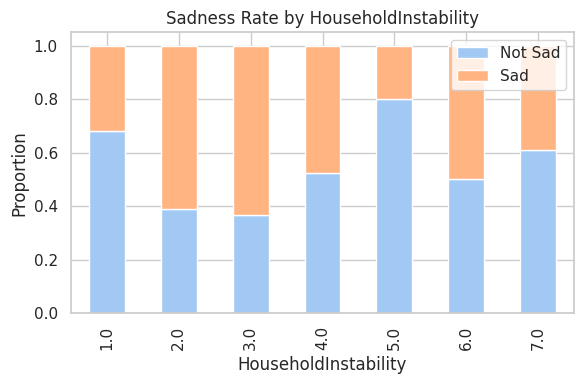

Chi-square p-value = 0.0000

 Analyzing Feature: Sex
Sex
2.0    2008
1.0    1197
Name: count, dtype: int64


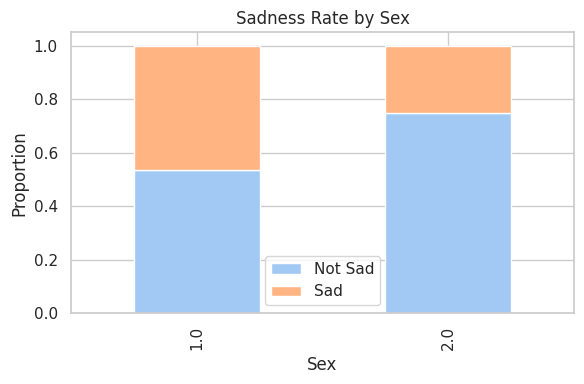

Chi-square p-value = 0.0000

 Analyzing Feature: Race
Race
1.0    1047
2.0     835
3.0     704
4.0     608
5.0      11
Name: count, dtype: int64


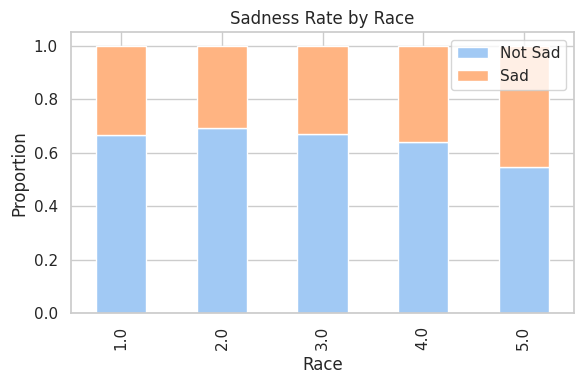

Chi-square p-value = 0.2951


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

%matplotlib inline

df_uni = df[features + [target]].copy()

sns.set(style="whitegrid", palette="pastel")

for col in features:
    print(f"\n Analyzing Feature: {col}")

    print(df_uni[col].value_counts(dropna=False))

    ct = pd.crosstab(df_uni[col], df_uni[target])
    ct.columns = ['Not Sad', 'Sad']
    ct_norm = ct.div(ct.sum(1), axis=0)

    ct_norm.plot(kind='bar', stacked=True, figsize=(6,4))
    plt.title(f'Sadness Rate by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    try:
        chi2, p, dof, ex = chi2_contingency(pd.crosstab(df_uni[col], df_uni[target]))
        print(f"Chi-square p-value = {p:.4f}")
    except:
        print("Chi-square test not possible for this feature (e.g., all values missing or constant).")


2.2 Correlation heatmap

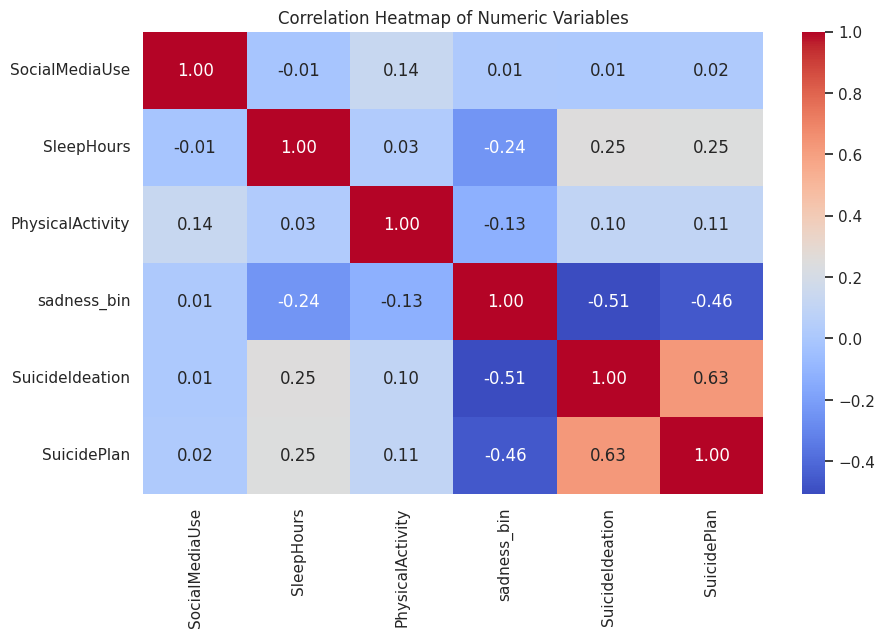

In [ ]:
num_cols = ['SocialMediaUse', 'SleepHours', 'PhysicalActivity',
            'sadness_bin', 'SuicideIdeation', 'SuicidePlan']

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()


Looks like social media use doesn't really have any noticeable effects, which is surprising. So, trying to analyse any underlying nonlinear relationship there might be here

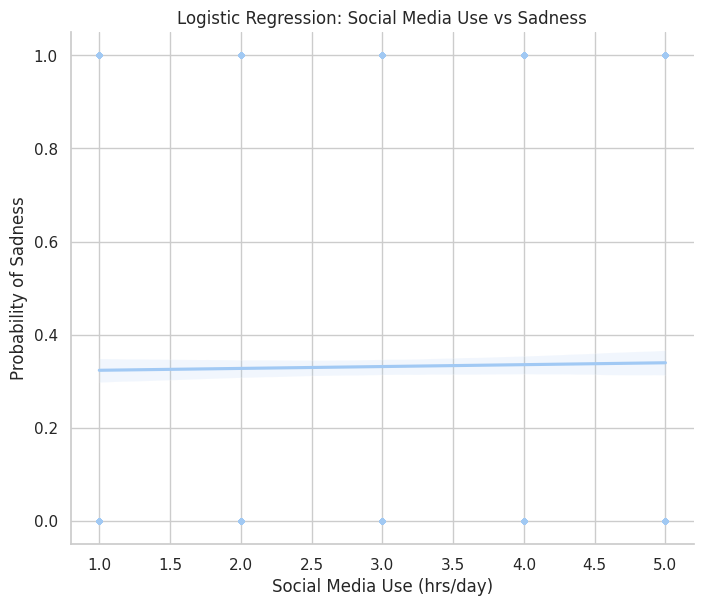

In [ ]:
sns.lmplot(x='SocialMediaUse', y='sadness_bin', data=df,
           logistic=True, scatter_kws={'s': 10}, height=6, aspect=1.2)
plt.title('Logistic Regression: Social Media Use vs Sadness')
plt.xlabel('Social Media Use (hrs/day)')
plt.ylabel('Probability of Sadness')
plt.show()


LOWESS plot (non-parametric smoothing) - to understand any other underlying nonlinearity between social media use and sadness

Text(0.5, 1.0, 'Lowess Smoothing: Social Media Use vs Sadness')

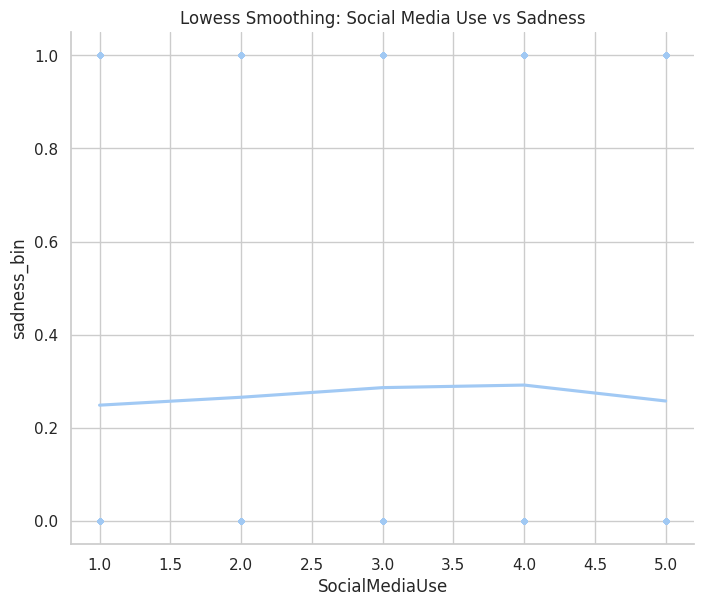

In [ ]:
sns.lmplot(x='SocialMediaUse', y='sadness_bin', data=df,
           lowess=True, scatter_kws={'s': 10}, height=6, aspect=1.2)
plt.title('Lowess Smoothing: Social Media Use vs Sadness')


The smoothed line gently increases from 1 to ~3–4 hours, then declines at 5 hours. This suggests a non-linear trend: mild increase in sadness probability with moderate social media use, but a slight drop at very high use.

Additional (this can be removed) - bivariate analysis

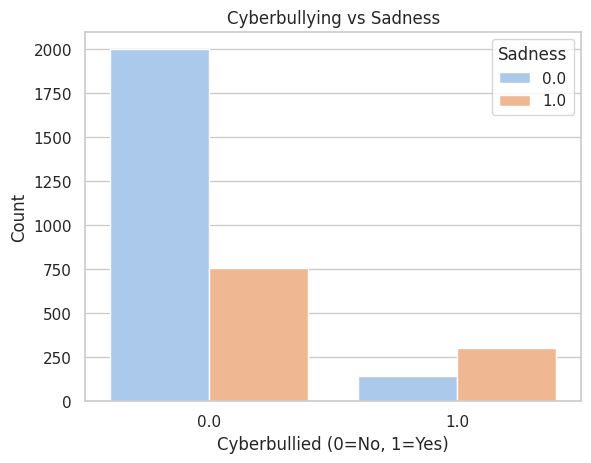

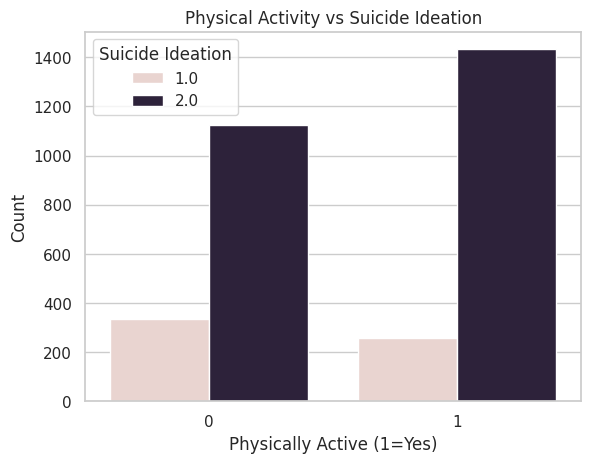

In [ ]:
# Cyberbullying vs Sadness
sns.countplot(data=df, x='cyberbully_bin', hue='sadness_bin')
plt.title('Cyberbullying vs Sadness')
plt.xlabel('Cyberbullied (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Sadness')
plt.show()

# Physical Activity vs Suicide Ideation
sns.countplot(data=df, x='active_bin', hue='SuicideIdeation')
plt.title('Physical Activity vs Suicide Ideation')
plt.xlabel('Physically Active (1=Yes)')
plt.ylabel('Count')
plt.legend(title='Suicide Ideation')
plt.show()


Modeling

In [ ]:
# STEP 7: Train/test split and scale numeric features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (for models that need scaling like logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data is now clean, encoded, and ready for modeling!")
print("Training features shape:", X_train.shape)


✅ Data is now clean, encoded, and ready for modeling!
Training features shape: (2564, 18)


In [ ]:
#Remove missing values from data set

# Step 1: Combine X and y into one DataFrame to safely drop rows with any NaNs in features
df_full = pd.concat([pd.DataFrame(X), pd.Series(y, name='target')], axis=1)

# Step 2: Drop all rows that contain any NaNs
df_full_clean = df_full.dropna()

# Step 3: Separate back into X and y
X_clean = df_full_clean.drop(columns=['target'])
y_clean = df_full_clean['target']

# Step 4: Redo train/test split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Missing values removed. Data ready for modeling!")
print("New shape of X:", X_clean.shape)


✅ Missing values removed. Data ready for modeling!
New shape of X: (2376, 18)


In [ ]:
# Convert all Boolean columns in X_clean to int (0/1)
X_clean = X_clean.astype(int)

# Re-split train/test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Rescale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


A. Logistic Regression

In [ ]:
#Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Create and fit the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate metrics
accuracy_lr = accuracy_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_proba)



📋 Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83       325
         1.0       0.68      0.30      0.41       151

    accuracy                           0.73       476
   macro avg       0.71      0.62      0.62       476
weighted avg       0.72      0.73      0.70       476



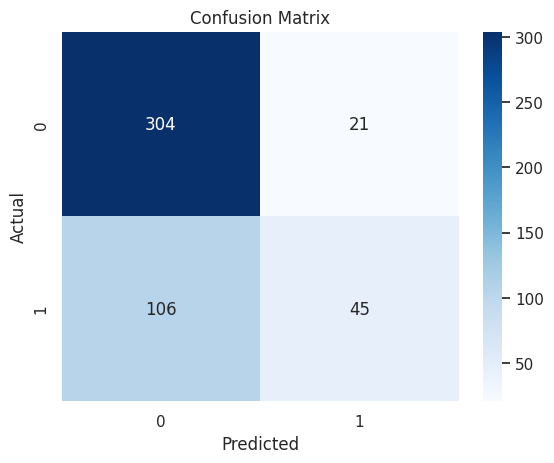

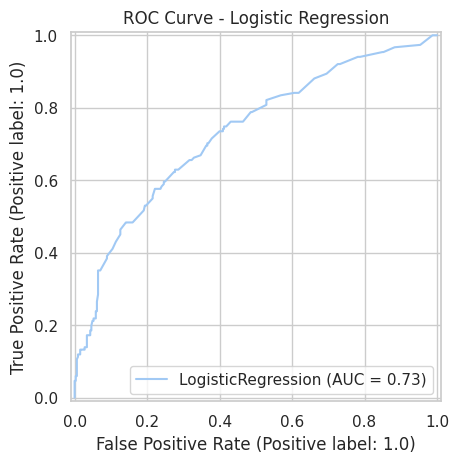

🔵 ROC AUC Score: 0.73


In [ ]:
#Evaluate Performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Print classification metrics
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

# Print ROC AUC score
print("🔵 ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 3))


B. KNN Classifier

KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.89      0.80       325
         1.0       0.53      0.27      0.36       151

    accuracy                           0.69       476
   macro avg       0.63      0.58      0.58       476
weighted avg       0.66      0.69      0.66       476



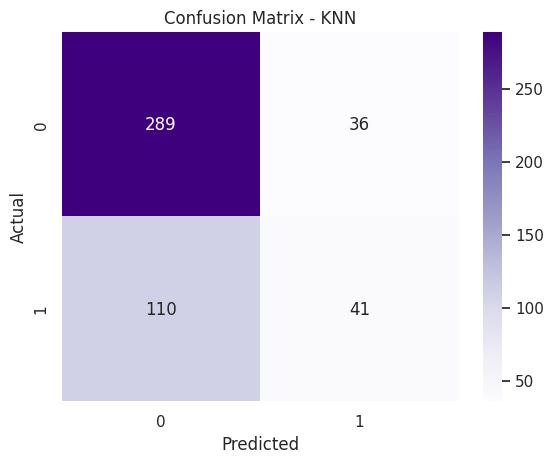

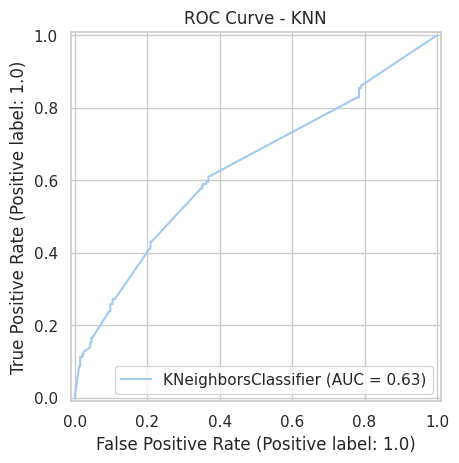

ROC AUC Score (KNN): 0.634


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

knn = KNeighborsClassifier(n_neighbors=6, weights='distance')  # we might have to tune this to improve performance

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(knn, X_test_scaled, y_test)
plt.title("ROC Curve - KNN")
plt.show()

print("ROC AUC Score (KNN):", round(roc_auc_score(y_test, y_proba_knn), 3))

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)



C. Random Forest Classifier

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.82       325
         1.0       0.72      0.19      0.29       151

    accuracy                           0.72       476
   macro avg       0.72      0.58      0.56       476
weighted avg       0.72      0.72      0.66       476



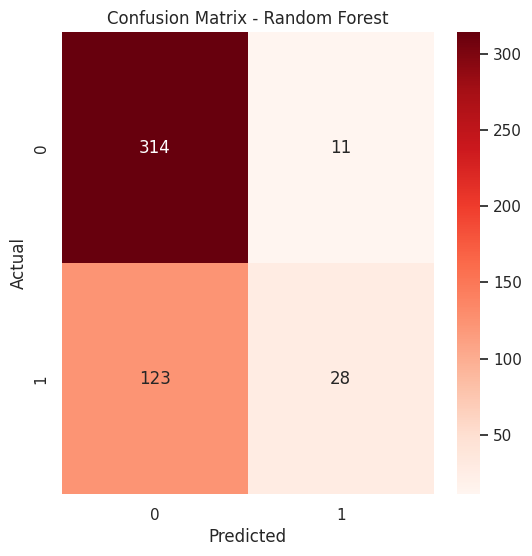

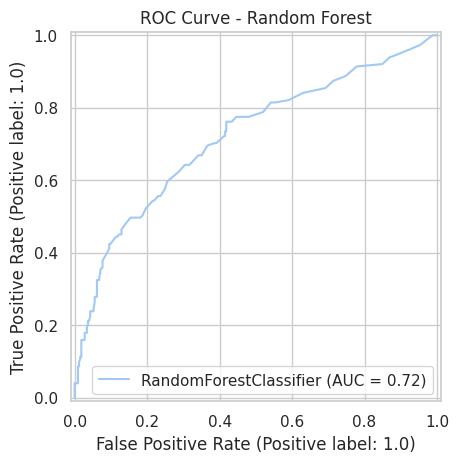

ROC AUC Score (RF): 0.719


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)

# 2. Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# 3. Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 4. Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

# 6. AUC Score
print("ROC AUC Score (RF):", round(roc_auc_score(y_test, y_proba_rf), 3))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)


D. Gradient Boosted Trees

GBT Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82       325
         1.0       0.67      0.26      0.38       151

    accuracy                           0.72       476
   macro avg       0.70      0.60      0.60       476
weighted avg       0.71      0.72      0.68       476



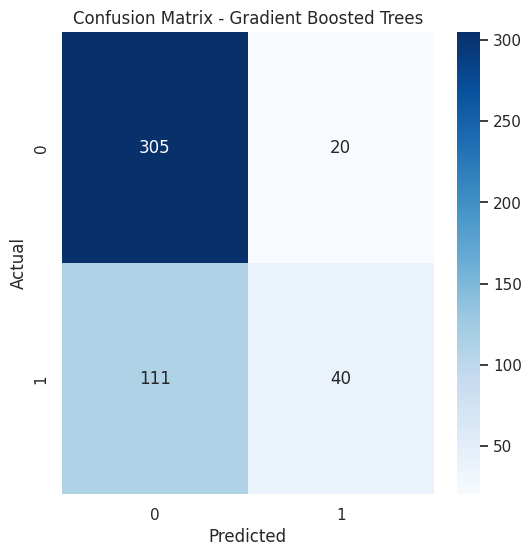

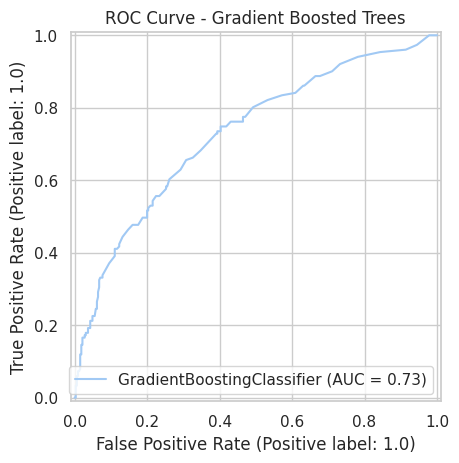

ROC AUC Score (GBT): 0.727


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train GBT (no scaling needed)
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)

# 2. Predictions
y_pred_gbt = gbt.predict(X_test)
y_proba_gbt = gbt.predict_proba(X_test)[:, 1]

# 3. Classification Report
print("GBT Classification Report:")
print(classification_report(y_test, y_pred_gbt))

# 4. Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_gbt),
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosted Trees")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. ROC Curve
RocCurveDisplay.from_estimator(gbt, X_test, y_test)
plt.title("ROC Curve - Gradient Boosted Trees")
plt.show()

# 6. AUC Score
print("ROC AUC Score (GBT):", round(roc_auc_score(y_test, y_proba_gbt), 3))

accuracy_gbt = accuracy_score(y_test, y_pred_gbt)
f1_gbt = f1_score(y_test, y_pred_gbt)
auc_gbt = roc_auc_score(y_test, y_proba_gbt)


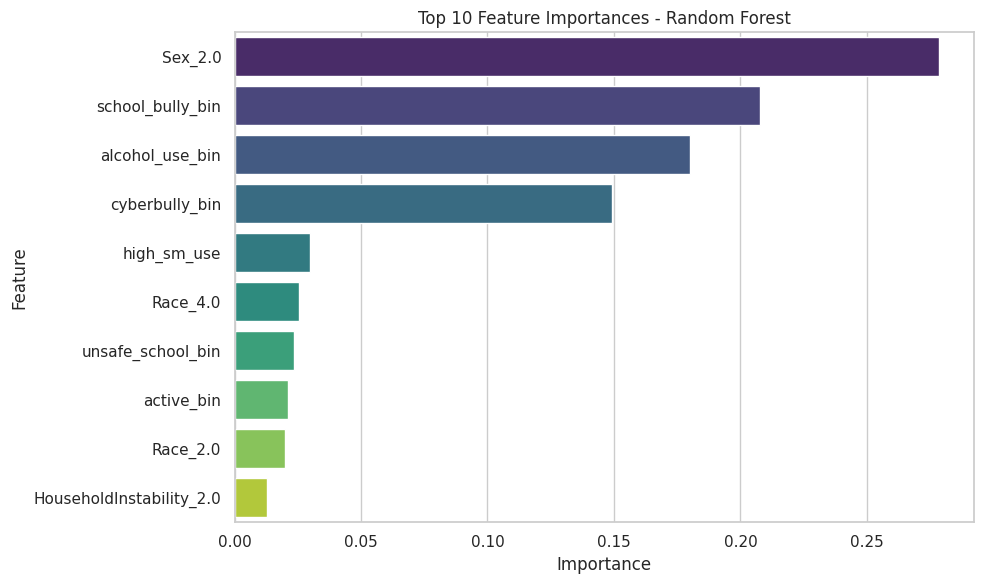

In [ ]:
# Top 10 Feature Importances - Random Forest
rf_importances = rf.feature_importances_
feature_names = X_train.columns
rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=rf_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()


Compare Models

In [ ]:
# Make table to compare
def get_f1(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return report['1']['f1-score'] if '1' in report else report['macro avg']['f1-score']

# Create comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Gradient Boosted Trees', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_gbt),
        accuracy_score(y_test, y_pred_rf)
    ],
    'ROC AUC': [
        roc_auc_score(y_test, y_proba),
        roc_auc_score(y_test, y_proba_knn),
        roc_auc_score(y_test, y_proba_gbt),
        roc_auc_score(y_test, y_proba_rf)
    ],
    'F1-Score': [
        get_f1(y_test, y_pred),
        get_f1(y_test, y_pred_knn),
        get_f1(y_test, y_pred_gbt),
        get_f1(y_test, y_pred_rf)
    ]
})

# Sort by ROC AUC and display
results.sort_values('ROC AUC', ascending=False, inplace=True)
print(results.to_markdown(index=False))

print("Key Takeaways:")
print("- Logistic Regression performed best overall with highest accuracy (73.3%), ROC AUC (0.73), and F1 Score (0.62)")
print("- Gradient Boosted Trees were a close second across all metrics")
print("- Random Forest showed decent accuracy but had a lower F1 Score, indicating weaker detection of the positive class")
print("- KNN performed worst, with the lowest ROC AUC and overall predictive power")


| Model                  |   Accuracy |   ROC AUC |   F1-Score |
|:-----------------------|-----------:|----------:|-----------:|
| Logistic Regression    |   0.733193 |  0.730443 |   0.620979 |
| Gradient Boosted Trees |   0.72479  |  0.727101 |   0.601179 |
| Random Forest          |   0.718487 |  0.71948  |   0.559442 |
| KNN                    |   0.693277 |  0.633612 |   0.578996 |
Key Takeaways:
- Logistic Regression performed best overall with highest accuracy (73.3%), ROC AUC (0.73), and F1 Score (0.62)
- Gradient Boosted Trees were a close second across all metrics
- Random Forest showed decent accuracy but had a lower F1 Score, indicating weaker detection of the positive class
- KNN performed worst, with the lowest ROC AUC and overall predictive power


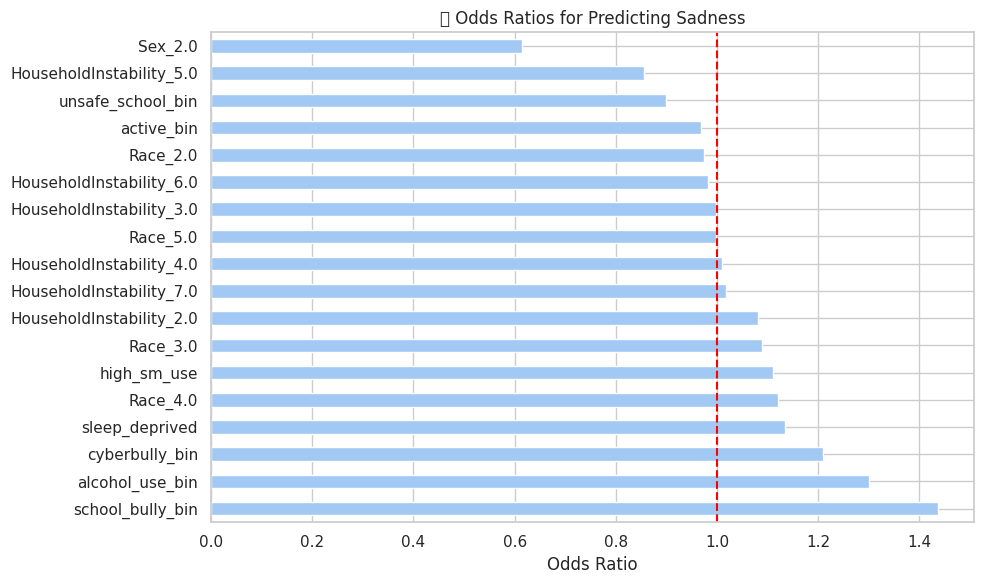

In [ ]:
# Interpret feature impact using odds ratios
odds_ratios = pd.Series(np.exp(lr.coef_[0]), index=X_train.columns)

# Plot
odds_ratios.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.axvline(x=1, color='red', linestyle='--')
plt.title("🔍 Odds Ratios for Predicting Sadness")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()


Improvements - Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.57      0.68       325
         1.0       0.45      0.77      0.57       151

    accuracy                           0.63       476
   macro avg       0.65      0.67      0.62       476
weighted avg       0.72      0.63      0.64       476



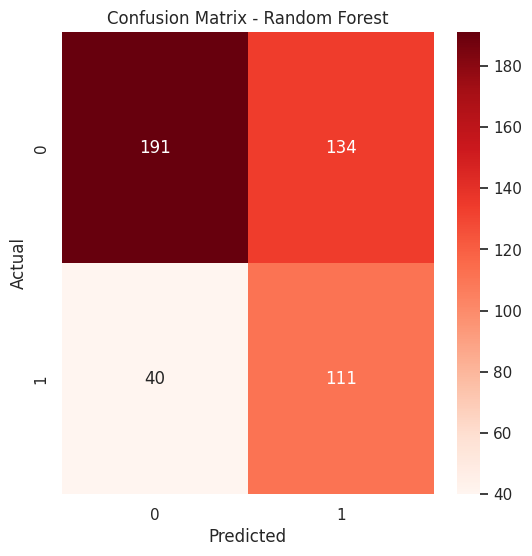

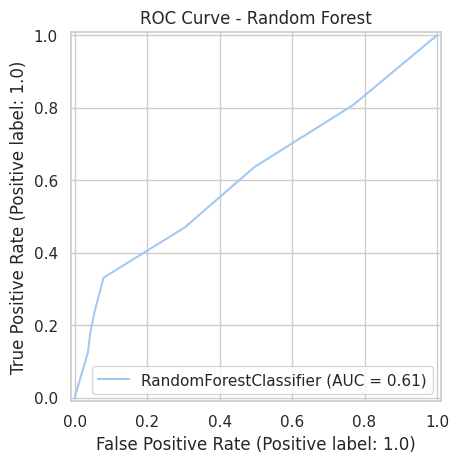

ROC AUC Score (RF): 0.725


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    class_weight={0: 1, 1: 2.5}, max_depth=5, n_estimators=200,
                       random_state=42
)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

threshold = 0.44
y_pred_thresh = (y_proba_rf >= threshold).astype(int)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_thresh))


plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

print("ROC AUC Score (RF):", round(roc_auc_score(y_test, y_proba_rf), 3))

In [ ]:
class_counts = pd.Series(y_train).value_counts()
print(class_counts)

print("\nClass Distribution (%):")
print(class_counts / len(y_train) * 100)

target
0.0    1308
1.0     592
Name: count, dtype: int64

Class Distribution (%):
target
0.0    68.842105
1.0    31.157895
Name: count, dtype: float64


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200, max_depth=5, random_state=42
    ))
])

pipe.fit(X_train_scaled, y_train)

y_pred = pipe.predict(X_test_scaled)
y_proba = pipe.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

         0.0       0.82      0.61      0.70       325
         1.0       0.46      0.72      0.56       151

    accuracy                           0.64       476
   macro avg       0.64      0.67      0.63       476
weighted avg       0.71      0.64      0.66       476

ROC AUC: 0.7271217524197657


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# avoiding class imbalance
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
}
grid_search = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_lr = grid_search.best_estimator_

print("Best Logistic Regression Model after Grid Search:")
print(best_lr)

y_pred_best_lr = best_lr.predict(X_test_scaled)
y_proba_best_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best_lr))

print("Logistic Regression ROC AUC Score (Best Model):", roc_auc_score(y_test, y_proba_best_lr))


Best Logistic Regression Model after Grid Search:
LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   solver='saga')
Logistic Regression Classification Report (Best Model):
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71       325
         1.0       0.47      0.72      0.57       151

    accuracy                           0.65       476
   macro avg       0.65      0.67      0.64       476
weighted avg       0.71      0.65      0.67       476

Logistic Regression ROC AUC Score (Best Model): 0.7306877228731533


Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       433
         1.0       0.69      0.41      0.52       208

    accuracy                           0.75       641
   macro avg       0.73      0.66      0.67       641
weighted avg       0.74      0.75      0.73       641

Accuracy: 0.749
ROC AUC: 0.723


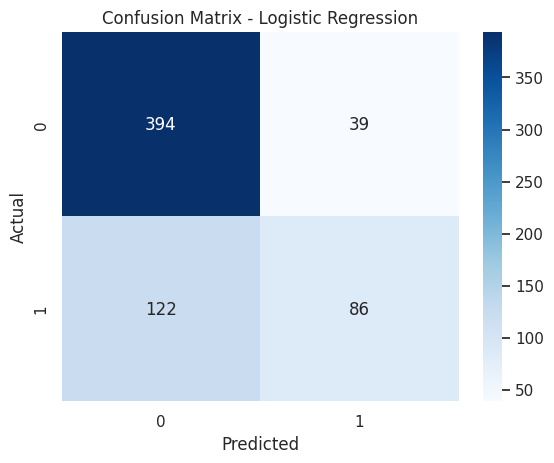

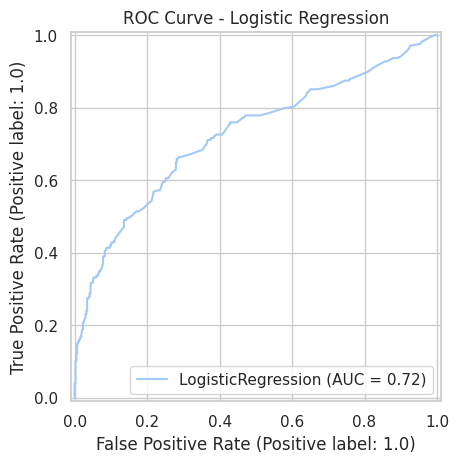

In [ ]:
# interaction
df['bully_sleep'] = df['cyberbully_bin'] * df['sleep_deprived']
df['alcohol_bully'] = df['alcohol_use_bin'] * df['school_bully_bin']
df['sm_sleep'] = df['high_sm_use'] * df['sleep_deprived']

# interaction
features = [
    'cyberbully_bin', 'school_bully_bin', 'active_bin', 'high_sm_use',
    'sleep_deprived', 'alcohol_use_bin', 'unsafe_school_bin',
    'bully_sleep', 'alcohol_bully', 'sm_sleep',
    'HouseholdInstability', 'Sex', 'Race'
]

target = 'sadness_bin'

# One-hot
df_model = pd.get_dummies(df[features + [target]], columns=['HouseholdInstability', 'Sex', 'Race'], drop_first=True)

# divide
X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardized
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# prediction
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# result
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()




KNN - Ling

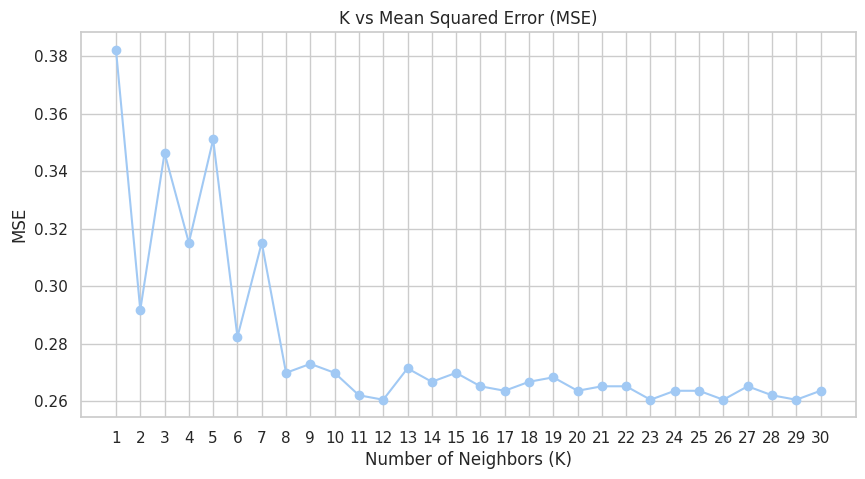

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# K range
k_values = list(range(1, 31))
mse_scores = []

# K and MSE
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train_scaled, y_train)
    y_pred_k = knn.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_k)
    mse_scores.append(mse)

# plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, mse_scores, marker='o')
plt.title("K vs Mean Squared Error (MSE)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("MSE")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
print("✅ Summary: Best model by AUC was:")
print(results.iloc[0])


✅ Summary: Best model by AUC was:
Model       Logistic Regression
Accuracy               0.733193
ROC AUC                0.730443
F1-Score               0.620979
Name: 0, dtype: object
